In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm


# Layer and models

In [6]:
class LinearODELayer(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(LinearODELayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    # the forward step
    def forward(self, x):
        output = x.mm(self.weight.reshape(2,2))
        if self.bias is not None:
            output += self.bias
        return output
    # the backward function is not necessary, sincewe have only used
    # functions from pytorch (in particular, .reshape and .mm)
    
    # this function is inherited from the pytorch class Linear
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
#Thsi object can be extended
class NonLinearODELayer(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(NonLinearODELayer, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.weight = nn.Parameter(torch.Tensor(self.in_dim, self.hid_dim, self.out_dim))
        
    def forward(self, x):
        xB = x.matmul(B).permute(0,2,1)
        xBx = x.matmul(xB.permute(1,0,2))
        out = torch.diagonal(xBx.permute(1,0,2))
        return out
    
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.srqt(9))
        
class LinearODEModel(nn.Module):
    def __init__(self, in_feature, out_feature, bias=False):
        super(LinearODEModel, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.bias = bias
        self.ode = LinearODELayer(self.in_feature, self.out_feature, self.bias)
        
    def forward(self, x):
        out = self.ode(x)
        return out
    
    
class NNODEModel(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(NNODEModel, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        
        self.lin_ode = LinearODELayer(self.in_dim, self.out_dim)
        self.nl_ode = NonLinearODELayer(self.in_dim, self.hid_dim, self.out_dim)
        
    def forward(self, x):
        out = self.lin_ode(x) + self.nl_ode(x)
        return out

# Training Pendulum with Linear ODE Model

In [3]:
kk = 0.01
AA = np.asarray([[1,1],[-kk,1]])

sol = [[0.99,1]]
for i in range(100):
    sol.append(np.dot(np.asarray(sol[-1]),AA))
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y)

print('train_x.shape:', train_x.shape)#train_input
print('train_y.shape:', train_y.shape)#train_output

train_x.shape: torch.Size([100, 2])
train_y.shape: torch.Size([100, 2])


Real weigths of the matrix:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 0.4557,  0.6042],
        [-0.6894,  0.4489]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9977,  0.9983],
        [-0.0100,  1.0000]], requires_grad=True)]


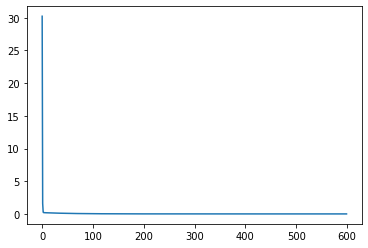

In [7]:
model = LinearODEModel(2, 2)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(AA)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):  # number of epochs
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Run our forward pass.
    prediction = model(train_x) #minibatches of size 1: to be modified
    # Step 3. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_fn(prediction, train_y)
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

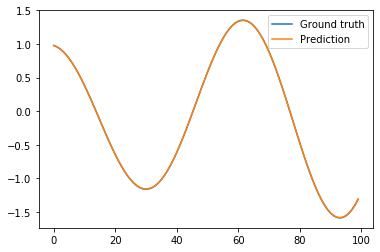

In [12]:
plt.plot(train_y[:,0].numpy(), label='Ground truth')
plt.plot(prediction[:,0].detach().numpy(), label='Prediction')
plt.legend()
plt.show()

# Training Lorenz attractor with Non Linear ODE model

In [30]:
sigma = 8
rho = 28
beta = 8/3

In [26]:
A = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]])
B = np.asarray([np.array([[0,0,0], [0,0,0], [0,0,0]]), np.array([[0,-1,0], [0,0,0], [0,0,0]]), np.array([[0,0,1], [0,0,0], [0,0,0]])])

sol = [[1,1,1]]

for i in range(100):
    x = sol[-1]
    Ax = np.dot(np.asarray(x),A)
    Bx = np.dot(B, x).T
    xBx = x.dot(Bx)
    f = 
    sol.append(np.dot(np.asarray(sol[-1]),A))

In [78]:
x = np.array([1,2,3])
x

array([1, 2, 3])

In [46]:
B = np.asarray([np.array([[0,0,0], [0,0,0], [0,0,0]]), np.array([[0,-1,0], [0,0,0], [0,0,0]]), np.array([[0,0,1], [0,0,0], [0,0,0]])])
B

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0, -1,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  1],
        [ 0,  0,  0],
        [ 0,  0,  0]]])

In [81]:
Bx = B.dot(x).T
Bx

array([[ 0, -2,  3],
       [ 0,  0,  0],
       [ 0,  0,  0]])

In [82]:
xBx = x.dot(Bx)
xBx

array([ 0, -2,  3])

In [68]:
x

array([0, 1, 2])